# CNN evaluation for MNIST

In [ ]:
#import adahessian
!pip install torch_optimizer
import torch_optimizer as ada_optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
#carregar mnist
trainset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
# Definir o Modelo
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128, bias=False),  # Ajustado para MNIST
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.out = nn.Linear(128, 10, bias=False)

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Achatar a saída
        x = self.fc1(x)
        output = self.out(x)
        return output

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.weight, 1e-4)  # Termo de regularização




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17489258.96it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 485309.56it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4502436.73it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4450018.40it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Instanciar o modelo
model = SimpleCNN().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar o modelo
def train(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #training
        model.train()
        train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_loss += loss.item()*inputs.size(0)
        train_loss = train_loss/len(trainloader.dataset)
        train_losses.append(train_loss)

        #validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(testloader.dataset)
        val_losses.append(val_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, epochs, train_loss, val_loss, 100 * correct / total))





    print("Finished Training/Validation")
    return train_losses.copy(), val_losses.copy()
# Avaliar o modelo
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    acc = correct/total
    return(acc)

#print(test(model, testloader))


#train(model, trainloader, testloader, criterion, optimizer, epochs=10)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=False)
)


In [ ]:
results={}


#ADAM
# Instanciar o modelo
model = SimpleCNN().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




model_perform={}

#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results['adam'] = model_perform
torch.save(model.state_dict(),'adam_cnn_mnist')

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=False)
)
Epoch [1/50], Train Loss: 0.2499, Val Loss: 0.0561, Val Acc: 98.17%
Epoch [2/50], Train Loss: 0.0836, Val Loss: 0.0396, Val Acc: 98.67%
Epoch [3/50], Train Loss: 0.0628, Val Loss: 0.0332, Val Acc: 98.89%
Epoch [4/50], Train Loss: 0.0501, Val Loss: 0.0365, Val Acc: 98.80%
Epoch [5/50], Train Loss: 0.0429, Val Loss: 0.0290, Val Acc: 99.09%
Epoch [6/50], Train Loss: 0.0368, Val Loss: 0.0316, Val A

KeyboardInterrupt: 

In [ ]:
#SGD

# Instanciar o modelo
model = SimpleCNN().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)



model_perform={}
#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results['sgd'] = model_perform
torch.save(model.state_dict(),'sgd_cnn_mnist')

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=False)
)
Epoch [1/50], Train Loss: 2.2968, Val Loss: 2.2836, Val Acc: 9.80%
Epoch [2/50], Train Loss: 2.2355, Val Loss: 2.1712, Val Acc: 9.80%
Epoch [3/50], Train Loss: 2.1245, Val Loss: 2.0795, Val Acc: 10.03%
Epoch [4/50], Train Loss: 2.0161, Val Loss: 1.8917, Val Acc: 31.48%
Epoch [5/50], Train Loss: 1.7375, Val Loss: 1.5704, Val Acc: 38.24%
Epoch [6/50], Train Loss: 1.4875, Val Loss: 1.2420, Val Acc

In [ ]:
# Treinar o modelo
def train_hess(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #training
        model.train()
        train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward(create_graph=True)
            optimizer.step()


            train_loss += loss.item()*inputs.size(0)
        train_loss = train_loss/len(trainloader.dataset)
        train_losses.append(train_loss)

        #validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(testloader.dataset)
        val_losses.append(val_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, epochs, train_loss, val_loss, 100 * correct / total))





    print("Finished Training/Validation")
    return train_losses.copy(), val_losses.copy()


#ADAHESSIAN

# Instanciar o modelo
model = SimpleCNN().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = ada_optim.Adahessian(model.parameters(), lr = 0.001)



model_perform={}
#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train_hess(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results['Adahessian'] = model_perform
torch.save(model.state_dict(),'adahessian_cnn_mnist')

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=12544, out_features=128, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (out): Linear(in_features=128, out_features=10, bias=False)
)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], Train Loss: 2.2947, Val Loss: 2.2673, Val Acc: 9.80%
Epoch [2/50], Train Loss: 2.1771, Val Loss: 2.0948, Val Acc: 9.82%
Epoch [3/50], Train Loss: 1.9934, Val Loss: 1.7852, Val Acc: 34.18%
Epoch [4/50], Train Loss: 1.5941, Val Loss: 1.3684, Val Acc: 56.40%
Epoch [5/50], Train Loss: 1.1366, Val Loss: 0.6912, Val Acc: 84.91%
Epoch [6/50], Train Loss: 0.7709, Val Loss: 0.4653, Val Acc: 88.85%
Epoch [7/50], Train Loss: 0.6170, Val Loss: 0.3661, Val Acc: 90.64%
Epoch [8/50], Train Loss: 0.5354, Val Loss: 0.3144, Val Acc: 91.66%
Epoch [9/50], Train Loss: 0.4747, Val Loss: 0.2799, Val Acc: 92.30%
Epoch [10/50], Train Loss: 0.4383, Val Loss: 0.2557, Val Acc: 92.93%
Epoch [11/50], Train Loss: 0.4000, Val Loss: 0.2349, Val Acc: 93.32%
Epoch [12/50], Train Loss: 0.3690, Val Loss: 0.2146, Val Acc: 93.72%
Epoch [13/50], Train Loss: 0.3441, Val Loss: 0.2025, Val Acc: 94.10%
Epoch [14/50], Train Loss: 0.3293, Val Loss: 0.1892, Val Acc: 94.41%
Epoch [15/50], Train Loss: 0.3138, Val Loss: 

In [ ]:
import json
with open('results.json', 'w') as f:
    json.dump(results, f)
results

{'adam': {'train_losses': [0.26131956635614234,
   0.0896457357292374,
   0.06722289584986865,
   0.05444564167720576,
   0.04840969718300427,
   0.03736640869868764,
   0.03242358250973436,
   0.03058921506209299,
   0.02947683299614194,
   0.025118084845043874,
   0.022612680671561976,
   0.02020563241460089,
   0.018186198018393284,
   0.018984738646948246,
   0.017817670136970505,
   0.01597351716365956,
   0.014634592052631585,
   0.01608299172146047,
   0.015164803734343755,
   0.015390329577247848,
   0.014594772738458838,
   0.013669402064727425,
   0.012632424566055124,
   0.012148334842712211,
   0.012509357156471439,
   0.010920427695697739,
   0.011180155706448567,
   0.011528485214798972,
   0.01071940603205682,
   0.011493877106890796,
   0.010562429350333635,
   0.011460895297020959,
   0.011088855561907198,
   0.009934286496134837,
   0.009915258030924353,
   0.01014118615625373,
   0.007335323775100914,
   0.010879274175009649,
   0.009365247010623488,
   0.00833323112

# MLP evaluation for MNIST

In [ ]:
#import adahessian
!pip install torch_optimizer
import torch_optimizer as ada_optim

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Carregar e Pré-processar o CIFAR-10




trainset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Definir o Modelo

class SimpleMLP(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        self.out = nn.Sequential(
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        output = self.out(x)
        return output

# Treinar o modelo
def train(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #training
        model.train()
        train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_loss += loss.item()*inputs.size(0)
        train_loss = train_loss/len(trainloader.dataset)
        train_losses.append(train_loss)

        #validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(testloader.dataset)
        val_losses.append(val_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, epochs, train_loss, val_loss, 100 * correct / total))





    print("Finished Training/Validation")
    return train_losses.copy(), val_losses.copy()

# Avaliar o modelo
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    acc = correct/total
    return(acc)


In [ ]:
results_mlp={}


#ADAM
# Instanciar o modelo
model = SimpleMLP().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)




model_perform={}

#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results_mlp['adam'] = model_perform
torch.save(model.state_dict(),'adam_mlp_mnist')

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
Epoch [1/50], Train Loss: 1.7440, Val Loss: 1.6579, Val Acc: 80.31%
Epoch [2/50], Train Loss: 1.6879, Val Loss: 1.6563, Val Acc: 80.45%
Epoch [3/50], Train Loss: 1.6597, Val Loss: 1.6339, Val Acc: 82.70%
Epoch [4/50], Train Loss: 1.6527, Val Loss: 1.6329, Val Acc: 82.81%
Epoch [5/50], Train Loss: 1.6476, Val Loss: 1.6514, Val Acc: 80.98%
Epoch [6/50], Train Loss: 1.6200, Val Loss: 1.5981, Val Acc: 86.29%
Epoch [7/50], Train Loss: 1.5811, Val Loss: 1.5589, Val Acc: 90.22%
Epoch [8/50], Train Loss: 1.5822, Val Loss: 1.5493, Val Acc: 91.19%
Epoch [9/50], Train Loss: 1.5731, Val Loss: 1.5825, Val Acc: 87.86%
Epoch [10/50], Train Loss: 1.5604, Val Loss: 1.5396, Val Acc: 92.14%
Epoch [

<Figure size 1000x1000 with 0 Axes>

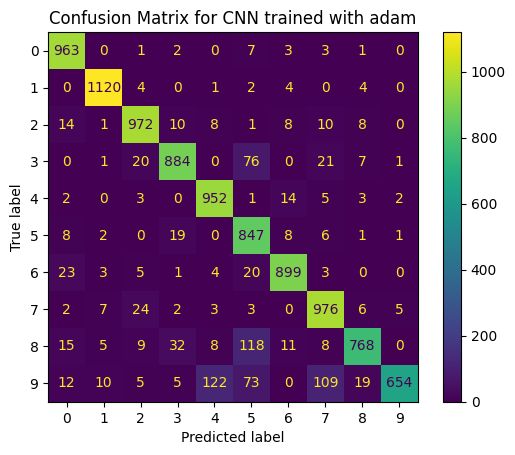

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for model_name, net in [('adam', model.to('cpu'))]:
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in testloader:
          output = net(inputs) # Feed Network

          #
          output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  disp.ax_.set_title(f'Confusion Matrix for CNN trained with {model_name}')
  disp.ax_.autoscale()



In [ ]:
#SGD

# Instanciar o modelo
model = SimpleMLP().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)



model_perform={}
#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results_mlp['sgd'] = model_perform
torch.save(model.state_dict(),'sgd_mlp_mnist')



SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
Epoch [1/50], Train Loss: 2.2869, Val Loss: 2.2593, Val Acc: 24.52%
Epoch [2/50], Train Loss: 2.1991, Val Loss: 2.1106, Val Acc: 51.35%
Epoch [3/50], Train Loss: 2.0022, Val Loss: 1.8993, Val Acc: 68.86%
Epoch [4/50], Train Loss: 1.8511, Val Loss: 1.8003, Val Acc: 72.85%
Epoch [5/50], Train Loss: 1.7825, Val Loss: 1.7383, Val Acc: 80.62%
Epoch [6/50], Train Loss: 1.7342, Val Loss: 1.7028, Val Acc: 81.95%
Epoch [7/50], Train Loss: 1.7077, Val Loss: 1.6823, Val Acc: 82.59%
Epoch [8/50], Train Loss: 1.6911, Val Loss: 1.6694, Val Acc: 83.05%
Epoch [9/50], Train Loss: 1.6792, Val Loss: 1.6603, Val Acc: 83.34%
Epoch [10/50], Train Loss: 1.6715, Val Loss: 1.6538, Val Acc: 83.58%
Epoch [

<Figure size 1000x1000 with 0 Axes>

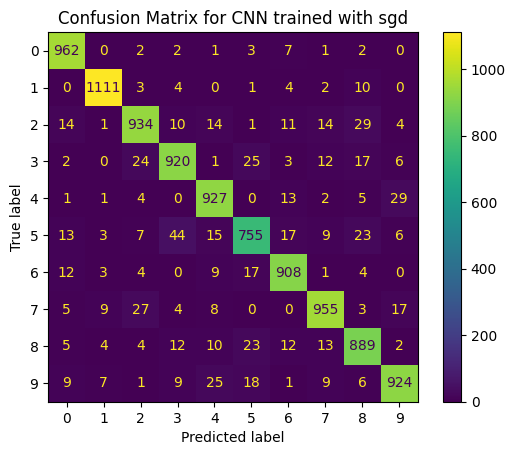

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for model_name, net in [('sgd', model.to('cpu'))]:
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in testloader:
          output = net(inputs) # Feed Network

          #
          output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot()
  disp.ax_.set_title(f'Confusion Matrix for CNN trained with {model_name}')
  disp.ax_.autoscale()



In [ ]:
def train_hess(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #training
        model.train()
        train_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward(create_graph=True)
            optimizer.step()


            train_loss += loss.item()*inputs.size(0)
        train_loss = train_loss/len(trainloader.dataset)
        train_losses.append(train_loss)

        #validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(testloader.dataset)
        val_losses.append(val_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, epochs, train_loss, val_loss, 100 * correct / total))





    print("Finished Training/Validation")
    return train_losses.copy(), val_losses.copy()



#ADAHESSIAN

# Instanciar o modelo
model = SimpleMLP().to(device)
print(model)

# Definir a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = ada_optim.Adahessian(model.parameters(), lr = 0.01)



model_perform={}
#treina o modelo com 30 epocas
model_perform['train_losses'], model_perform['validation_losses'] = train_hess(model, trainloader, testloader, criterion, optimizer, epochs=50)
model_perform['accuracy'] = test(model, testloader)
results_mlp['Adahessian'] = model_perform
torch.save(model.state_dict(),'adahessian_mlp_mnist')

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1203.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/50], Train Loss: 1.9365, Val Loss: 1.6878, Val Acc: 82.41%
Epoch [2/50], Train Loss: 1.6410, Val Loss: 1.5909, Val Acc: 90.27%
Epoch [3/50], Train Loss: 1.5908, Val Loss: 1.5695, Val Acc: 91.28%
Epoch [4/50], Train Loss: 1.5741, Val Loss: 1.5586, Val Acc: 91.92%
Epoch [5/50], Train Loss: 1.5634, Val Loss: 1.5515, Val Acc: 92.40%
Epoch [6/50], Train Loss: 1.5559, Val Loss: 1.5453, Val Acc: 92.67%
Epoch [7/50], Train Loss: 1.5498, Val Loss: 1.5410, Val Acc: 93.05%
Epoch [8/50], Train Loss: 1.5448, Val Loss: 1.5369, Val Acc: 93.40%
Epoch [9/50], Train Loss: 1.5401, Val Loss: 1.5336, Val Acc: 93.62%
Epoch [10/50], Train Loss: 1.5365, Val Loss: 1.5303, Val Acc: 93.87%
Epoch [11/50], Train Loss: 1.5328, Val Loss: 1.5277, Val Acc: 94.09%
Epoch [12/50], Train Loss: 1.5301, Val Loss: 1.5249, Val Acc: 94.35%
Epoch [13/50], Train Loss: 1.5269, Val Loss: 1.5227, Val Acc: 94.56%
Epoch [14/50], Train Loss: 1.5246, Val Loss: 1.5204, Val Acc: 94.70%
Epoch [15/50], Train Loss: 1.5221, Val Loss

In [ ]:
import json
with open('results_mlp.json', 'w') as f:
    json.dump(results_mlp, f)
results_mlp

{'adam': {'train_losses': [1.7440027002970377,
   1.6878881035486857,
   1.6597168068567911,
   1.652656618754069,
   1.6475850638707479,
   1.619951163482666,
   1.5811129364649454,
   1.582164627901713,
   1.5731289651870728,
   1.5603796421686809,
   1.5633318165461223,
   1.562521678352356,
   1.5527676167170206,
   1.5558801758448282,
   1.5536311809539796,
   1.5594845660527548,
   1.5713945536931355,
   1.559532341448466,
   1.5607819140752157,
   1.556605826250712,
   1.5593135568618774,
   1.5729965037663778,
   1.5504244391759237,
   1.5523983770370484,
   1.5501933876037597,
   1.5518926674524942,
   1.5540802028020222,
   1.5590843603134155,
   1.549485893058777,
   1.5617673774719238,
   1.5625192415237428,
   1.5593195320765176,
   1.5573943567276,
   1.556310163561503,
   1.5557452324549357,
   1.5607001494725545,
   1.5568568576176962,
   1.556688649559021,
   1.5735858699162801,
   1.5559359983444214,
   1.5683875895818074,
   1.5533106349309285,
   1.5569605653762817,